# 🌍 ITCZ Experiment

#### Originally created by Dr. Ipshita Dey (NCAS, Univerity of Reading)

## ☁️🌧️ Inter-Tropical Convergence Zone (ITCZ) 
The ITCZ appears as a band of low-pressure and clouds that encircles the globe near the equator. The solid band of clouds may extend for many hundreds of miles and is sometimes broken into smaller line segments. Its existence is due to the convergence of the trade winds: winds in the tropics that move predominantly from the east and curve towards the equator. When the northeast trade winds from the Northern Hemisphere and the southeast winds from the Southern Hemisphere come together, it forces the air up into the atmosphere, forming the ITCZ.

The ITCZ can be identified using the latitudinal profile of zonal mean precipitation (convective) or outgoing longwave radiation, whose peak would be indicative of the strength and location of the ITCZ.

The ITCZ moves throughout the year and follows the migration of the Sun’s overhead position typically with a delay of around 1-2 months, and generally favors the warmer hemisphere. The ITCZ shifts are more dramatic over land, as land heats up faster than ocean, the ITCZ tends to move further north and south over land areas than that over water. Due to the unequal distribution of land and ocean between hemispheres, the annual ITCZ tends to be located slightly north of the equator. 

## 🎯 Objective
Examine the sensitivity of the ITCZ location to maximum sea-surface temperatures (SST), meridional SST gradients, land-sea distribution and warming/cooling.

## 🔬 🧠 Guiding Questions

- Is the ITCZ in the Earth-like climate as sensitive to the changes (max sst, latitude of max sst, warming/cooling) as that in the AquaPlanet simulations?
  
- Is it possible to get a fully zonal ITCZ in an Earth-like climate?

  
- What changes in the ITCZ can we expect in an Earth-like climate with anthropogenic warming? Is there a way to mimic such a warming signal in the model setup?

## 💾 Variables to Investigate
To investigate the shifts in ITCZ, you should save the following variables from your simulation output:

- **Sea Surface Temperature (SST)** `simulation.prognostic_variables.ocean.sea_surface_temperature`

- **Precipitation (Convective)** `simulation.diagnostic_variables.physics.rain_convection`

- **Outgoing Longwave Radiation** `simulation.diagnostic_variables.outgoing_longwave_radiation`

👉 You may also consider saving additional variables depending on the focus of your analysis.

In [1]:
using Pkg
Pkg.develop("SpeedyWeather")
Pkg.status("SpeedyWeather")
# Pkg.add("SpeedyWeather")
#Pkg.add(url="https://github.com/SpeedyWeather/SpeedyWeather.jl",rev="Main")


Status `~/.julia/environments/v1.11/Project.toml`
  [9e226e20] SpeedyWeather v0.16.0 `~/.julia/dev/SpeedyWeather`


In [2]:
using SpeedyWeather
using Statistics
using CairoMakie

[ Info: Precompiling SpeedyWeather [9e226e20-d153-4fed-8a5b-493def4f21a9] (cache misses: wrong dep version loaded (2), incompatible header (4))
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0] (cache misses: wrong dep version loaded (2), incompatible header (4))
[ Info: Precompiling StructArraysGPUArraysCoreExt [cbbf52aa-d660-55d4-8a5a-33845bbaa85d] (cache misses: wrong dep version loaded (2), incompatible header (4))
[ Info: Precompiling DomainSetsMakieExt [da481366-01c8-5b4d-b359-47a10c8532e7] (cache misses: incompatible header (2))
[ Info: Precompiling ModelParametersMakieExt [fe55f67a-76af-556c-8c6e-f9ee716b975d] (cache misses: incompatible header (2))
[ Info: Precompiling SpeedyWeatherMakieExt [5b33269b-99f4-5abe-8178-09ad803418e6] (cache misses: wrong dep version loaded (2), incompatible header (4))


In [3]:
function zonal_nanmean(field::AbstractField)
    # field = sst
    ks = size(field)[2:end]

    # determine type T after division with integer (happening in mean)
    T = Base.promote_op(/, eltype(field), Int64)
    m = zeros(T, RingGrids.get_nlat(field), ks...)

    rings = eachring(field.grid)
    for k in eachlayer(field)
        for (j, ring) in enumerate(rings)
            m[j, k] = mean(filter(!isnan, field[ring, k]))
        end
    end
    return m
end

zonal_nanmean (generic function with 1 method)

## 🔎📊 Examine ITCZ sensitivity using Aquaplanet simulations

📌 The Aquaplanet setup is a common next step for weather and climate modellers when testing a new dynamical core.

It removes the complexity of land–sea contrasts and surface parametrisations, offering a pure testbed for atmospheric fluid dynamics.
With a uniform ocean surface and idealized physics, it's easier to isolate and understand:

- How the model handles large-scale circulation

- The behavior of tropical convection and jet streams

- The emergence of baroclinic instabilities and equatorial waves

By focusing on a simplified configuration, modellers can more clearly evaluate the stability, realism, and biases of their numerical schemes.

In [45]:
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid, snow=true)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid) # basically setting land mask 0 everywhere
orography = NoOrography(spectral_grid)
ocean = AquaPlanet(spectral_grid, temp_equator=302, temp_poles=273, mask=true)

model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation = initialize!(model)
run!(simulation, period=Day(180))
nothing

Weather is speedy: 100%|██████████████████| Time: 0:00:49 (861.14 years/day)


In [4]:
simulation.diagnostic_variables.physics

PhysicsVariables
├ grid: OctahedralGaussianGrid{SpeedyWeatherInternals.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}
├ ocean: DynamicsVariablesOcean{Float32, Array, OctahedralGaussianGrid{SpeedyWeatherInternals.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeatherInternals.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ land: DynamicsVariablesLand{Float32, Array, OctahedralGaussianGrid{SpeedyWeatherInternals.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}, Field{Float32, 1, Vector{Float32}, OctahedralGaussianGrid{SpeedyWeatherInternals.Architectures.CPU{KernelAbstractions.CPU}, Vector{UnitRange{Int64}}, Vector{Int64}}}}
├ rain_large_scale: 3168-element, 48-ring Field{Float32}
├ rain_convection: 3168-element, 48-ring Field{Float32}
├ snow_large_scale: 3168-element, 48-ring 

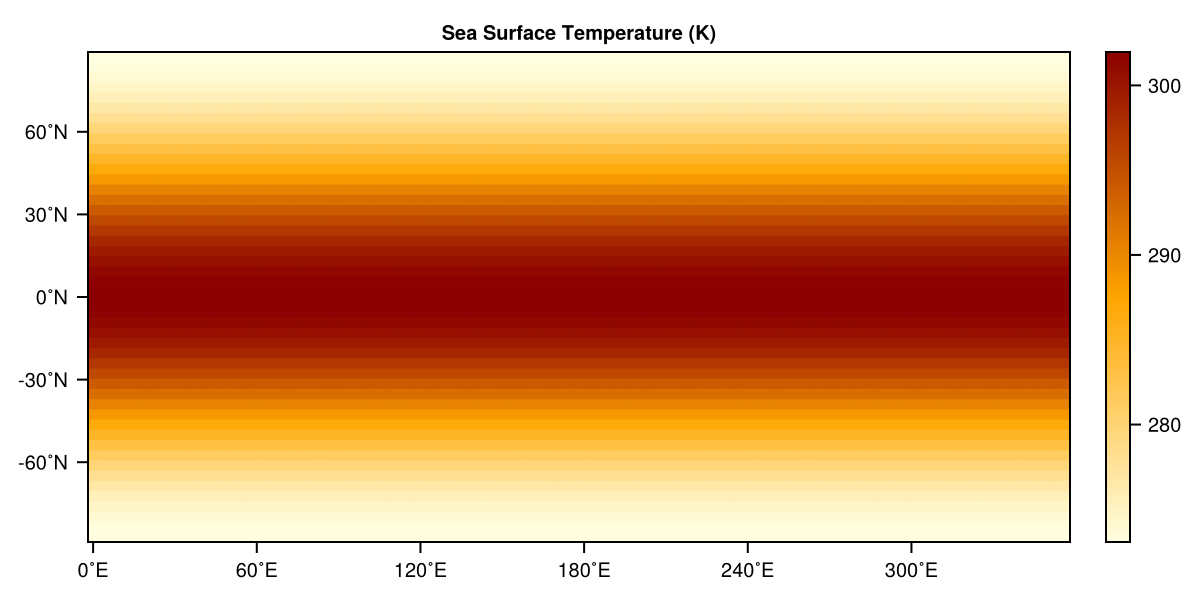

In [5]:
sst = simulation.prognostic_variables.ocean.sea_surface_temperature
fig=heatmap(sst, title="Sea Surface Temperature (K)", colormap=:heat)
# save("aquaplanet.png", fig) 

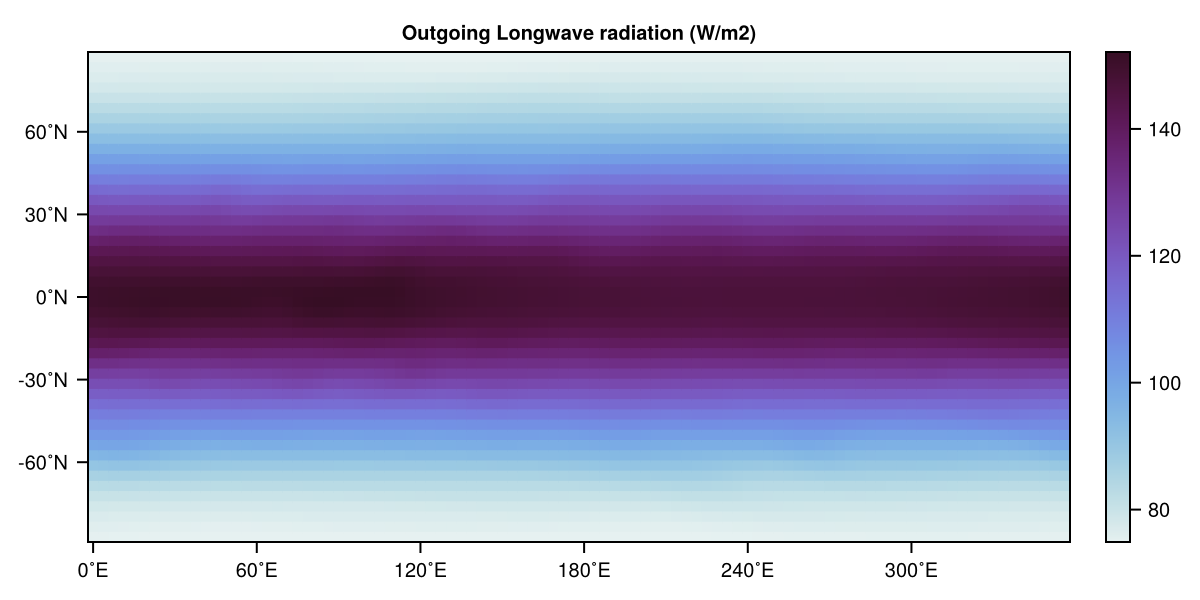

In [6]:
olr = simulation.diagnostic_variables.physics.outgoing_longwave_radiation
fig=heatmap(olr, title="Outgoing Longwave radiation (W/m2)", colormap=:dense)

Precipitation (both large-scale and convective) are written into the
`simulation.diagnostic_variables.physics` which, however, accumulate all precipitation
during simulation. In the NetCDF output, precipitation rate (in mm/hr) is calculated
from accumulated precipitation as a post-processing step.
More interactively, you can also reset these accumulators and integrate for another 6 hours
to get the precipitation only in that period.

In [6]:
# reset accumulators and simulate 10 days
simulation.diagnostic_variables.physics.rain_large_scale .= 0
simulation.diagnostic_variables.physics.rain_convection .= 0
run!(simulation, period=Day(10))

Weather is speedy: 100%|██████████████████| Time: 0:00:02 (841.38 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

As the precipitation fields are accumulated meters over the integration period
we divide by number of hours to get a precipitation rate ``[m/hr]``
but then multiply with 1 hour and 1000 to get the typical precipitation unit of ``[mm/hr]``.

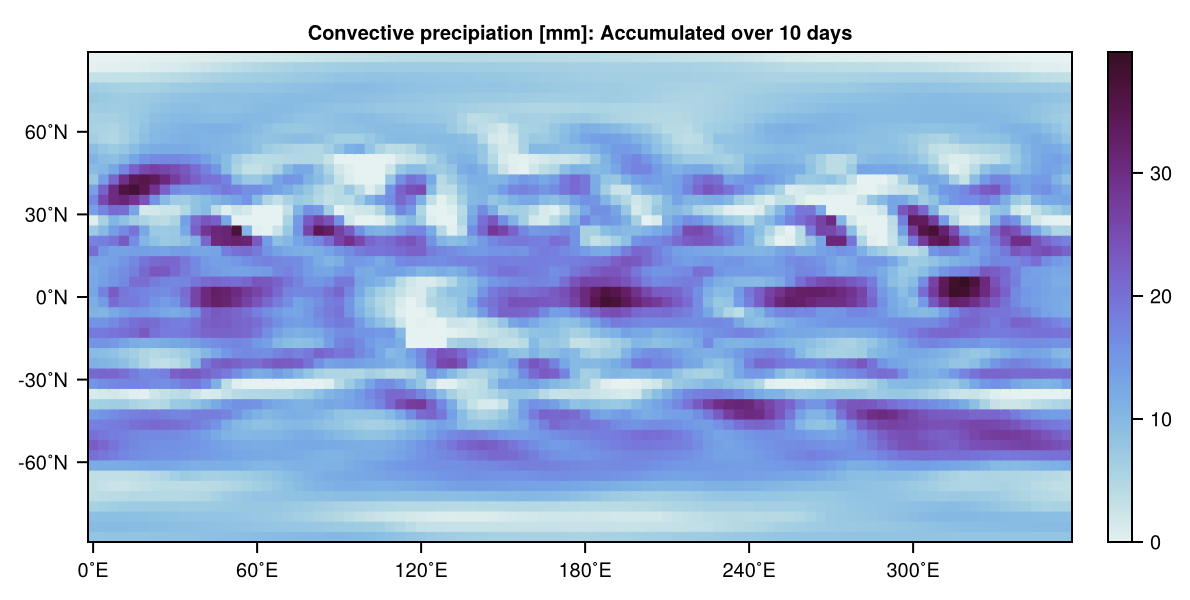

In [7]:
(; rain_large_scale, rain_convection) = simulation.diagnostic_variables.physics
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*rain_convection, title="Convective precipiation [mm]: Accumulated over 10 days", colormap=:dense)
fig

## 1️⃣ 🌡️ Changing SST at equator or equivalently changing the equator-pole SST gradient

In [8]:
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)

# create model, initialize, run
# Experiment-1: SST @ Equator = 302.0 K; SST @ Poles = 273.0 K; default settings
ocean = AquaPlanet(spectral_grid, temp_equator=302.0, temp_poles=273.0)
model1 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation1 = initialize!(model1)
run!(simulation1, period=Day(180))

# Experiment-2: SST @ Equator = 303.5 K; SST @ Poles = 273.0 K
ocean = AquaPlanet(spectral_grid, temp_equator=303.5, temp_poles=273.0)
model2 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation2 = initialize!(model2)
run!(simulation2, period=Day(180))

# Experiment-3: SST @ Equator = 300.5 K; SST @ Poles = 273.0 K
ocean = AquaPlanet(spectral_grid, temp_equator=300.5, temp_poles=273.0)
model3 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation3 = initialize!(model3)
run!(simulation3, period=Day(180))

nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:00:49 (854.99 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:49 (853.00 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:49 (858.91 years/day)


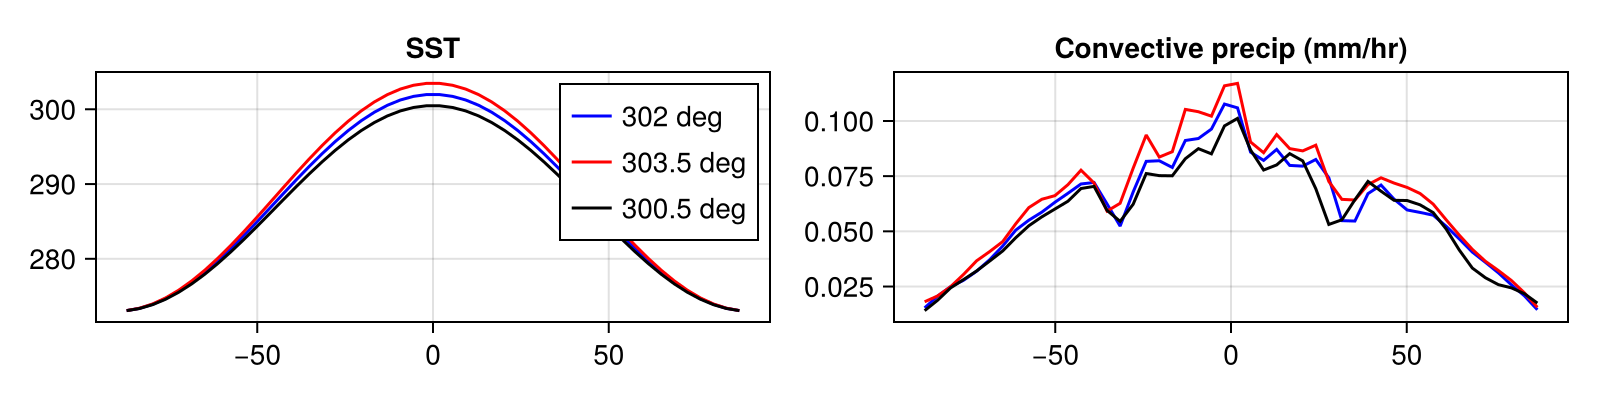

In [10]:
m2mm_hr = (1000*Hour(1)/Hour(180*24)) 
(; rain_large_scale, rain_convection) = simulation1.diagnostic_variables.physics
precip1 = m2mm_hr*rain_convection
sst1 = simulation1.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation2.diagnostic_variables.physics
precip2 = m2mm_hr*rain_convection
sst2 = simulation2.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation3.diagnostic_variables.physics
precip3 = m2mm_hr*rain_convection
sst3 = simulation3.prognostic_variables.ocean.sea_surface_temperature

(; Grid, nlat_half) = model1.spectral_grid
latd = RingGrids.get_latd(Grid, nlat_half)

fig = Figure(size = (800, 200));
axs = [Axis(fig[row, col]) for row in 1: 1, col in 1:2]

l1 = lines!(axs[1,1], latd, zonal_mean(sst1),color=:blue)
l2 = lines!(axs[1,1], latd, zonal_mean(sst2),color=:red)
l3 = lines!(axs[1,1], latd, zonal_mean(sst3),color=:black)
axs[1,1].title = "SST"
axislegend(axs[1,1],[l1,l2,l3],["302 deg","303.5 deg","300.5 deg"],position = (1,1), orientation = :vertical)

l1 = lines!(axs[1,2], latd, zonal_mean(precip1),color=:blue)
l2 = lines!(axs[1,2], latd, zonal_mean(precip2),color=:red)
l3 = lines!(axs[1,2], latd, zonal_mean(precip3),color=:black)
axs[1,2].title = "Convective precip (mm/hr)"

fig

## 2️⃣ 🌀 Changing latitudes of maximum sst

In [11]:
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)
ocean = AquaPlanet(spectral_grid, temp_equator=302.0, temp_poles=273.0)

# Experiment-1: Max SST @ Equator - 20 deg
model1 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation1 = initialize!(model1)
sst1 = simulation1.prognostic_variables.ocean.sea_surface_temperature
set!(sst1, (λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ+20.)^2)
# set!(simulation1, sea_surface_temperature=(λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ+20.)^2) # also does the same thing
run!(simulation1, period=Day(180))

# Experiment-2: Max SST @ Equator # default settings
model2 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation2 = initialize!(model2)
sst2 = simulation2.prognostic_variables.ocean.sea_surface_temperature
set!(sst2, (λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ)^2)
# set!(simulation2, sea_surface_temperature=(λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ)^2) # also does the same thing
run!(simulation2, period=Day(180))

# Experiment-3: Max SST @ Equator + 20 deg 
model3 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation3 = initialize!(model3)
sst3 = simulation3.prognostic_variables.ocean.sea_surface_temperature
set!(sst3, (λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ-20.)^2)
# set!(simulation3, sea_surface_temperature=(λ, φ) -> 273.0 + (302.0-273.0)*cosd(φ-20.0)^2) # also does the same thing
run!(simulation3, period=Day(180))

nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:00:51 (821.63 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:52 (803.95 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:52 (818.78 years/day)


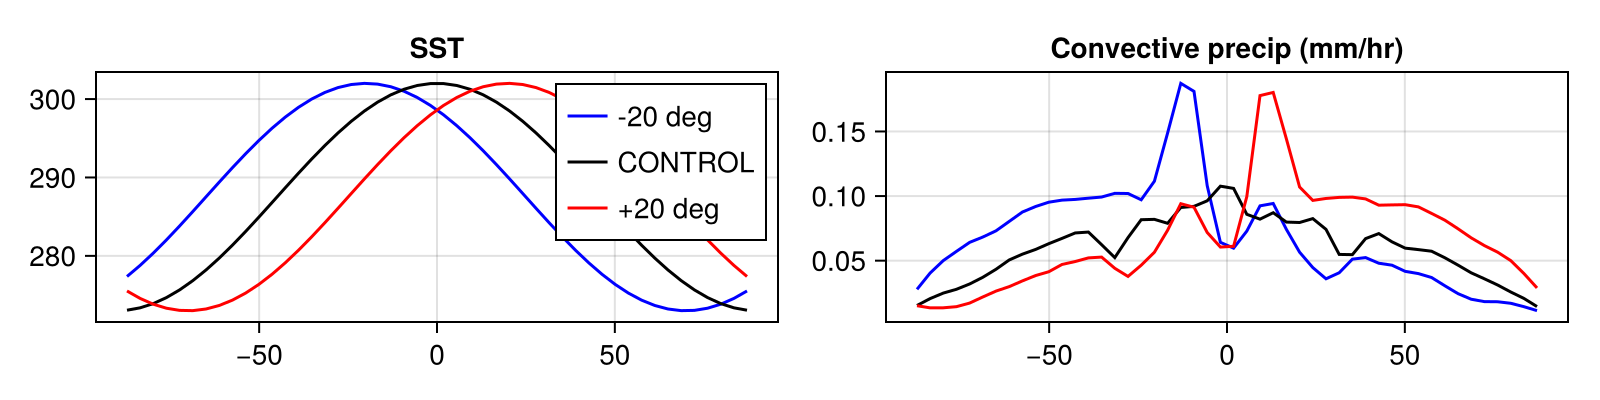

In [12]:
m2mm_hr = (1000*Hour(1)/Hour(180*24)) 
(; rain_large_scale, rain_convection) = simulation1.diagnostic_variables.physics
precip1 = m2mm_hr*rain_convection
sst1 = simulation1.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation2.diagnostic_variables.physics
precip2 = m2mm_hr*rain_convection
sst2 = simulation2.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation3.diagnostic_variables.physics
precip3 = m2mm_hr*rain_convection
sst3 = simulation3.prognostic_variables.ocean.sea_surface_temperature

(; Grid, nlat_half) = model1.spectral_grid
latd = RingGrids.get_latd(Grid, nlat_half)

fig = Figure(size = (800, 200));
axs = [Axis(fig[row, col]) for row in 1: 1, col in 1:2]

l1 = lines!(axs[1,1], latd, zonal_mean(sst1),color=:blue)
l2 = lines!(axs[1,1], latd, zonal_mean(sst2),color=:black)
l3 = lines!(axs[1,1], latd, zonal_mean(sst3),color=:red)
axs[1,1].title = "SST"
axislegend(axs[1,1], [l1, l2, l3], ["-20 deg", "CONTROL","+20 deg"], position = (1,1), orientation = :vertical)
# axislegend(ax = axs[1,1], position = (1,1), orientation = :horizontal)
# hidexdecorations!(axs[1,1])

l1 = lines!(axs[1,2], latd, zonal_mean(precip1),color=:blue)
l2 = lines!(axs[1,2], latd, zonal_mean(precip2),color=:black)
l3 = lines!(axs[1,2], latd, zonal_mean(precip3),color=:red)
axs[1,2].title = "Convective precip (mm/hr)"
# # hidexdecorations!(axs[1,1])
# axislegend(axs[1,1], [l1, l2, l3], ["One", "Two","Three"], position = :rb, orientation = :horizontal)

fig

## 3️⃣ 🏝️🌊 Changing land-sea distribution

Weather is speedy: 100%|██████████████████| Time: 0:00:02 (871.62 years/day)


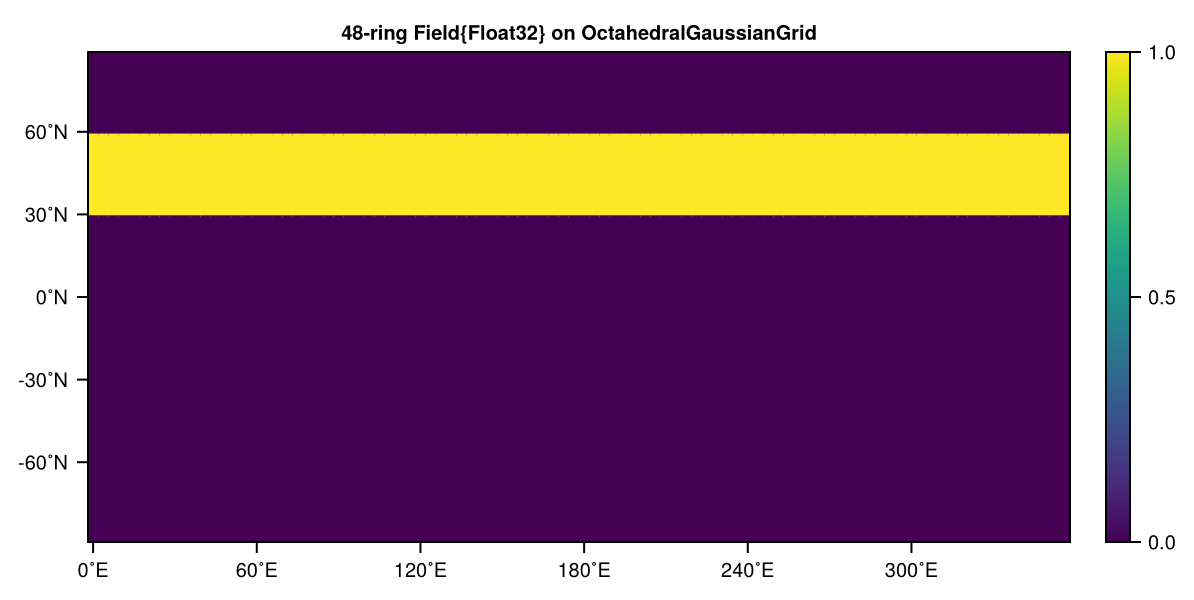

In [27]:
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)
ocean = AquaPlanet(spectral_grid, temp_equator=302, temp_poles=273, mask=true)

model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation = initialize!(model)

sst_org = zonal_mean(sst)
# set!(land_sea_mask.mask, (λ, φ) -> 1.0) #Rocky planet
# set!(land_sea_mask.mask, (λ, φ) -> 0.0) #Aqua planet
# set!(land_sea_mask.mask, (λ, φ) -> (30 < φ < 60) ? 1 : 0) # landmass between 30-60 N
set!(model, land_sea_mask=(λ, φ) -> (30 < φ < 60) ? 1 : 0) # also does the same thing

run!(simulation, period=Day(10))

(; rain_large_scale, rain_convection) = simulation.diagnostic_variables.physics
sst = simulation.prognostic_variables.ocean.sea_surface_temperature

heatmap(model.land_sea_mask.mask)

In [35]:
# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)
ocean = AquaPlanet(spectral_grid, temp_equator=302.0, temp_poles=273.0, mask=true)

# Experiment-1: Aquaplanet
model1 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation1 = initialize!(model1)
set!(model1, land_sea_mask=(λ, φ) -> 0.0) 
run!(simulation1, period=Day(180))

# Experiment-2: Rocky planet
model2 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation2 = initialize!(model2)
set!(model2, land_sea_mask=(λ, φ) -> 1.0) 
run!(simulation2, period=Day(180))

# Experiment-3: landmass between 0-90 N
model3 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation3 = initialize!(model3)
set!(model3, land_sea_mask=(λ, φ) -> (0.0 <= φ <= 90.0) ? 1 : 0) 
run!(simulation3, period=Day(180))

# Experiment-4: landmass between 0-90 S
model4 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation4 = initialize!(model4)
set!(model4, land_sea_mask=(λ, φ) -> (-90.0 <= φ < 0.0) ? 1 : 0) 
run!(simulation4, period=Day(180))


Weather is speedy: 100%|██████████████████| Time: 0:00:03 (716.04 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:02 (843.82 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:02 (863.32 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:02 (820.47 years/day)


Simulation{PrimitiveWetModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveWetModel{...}

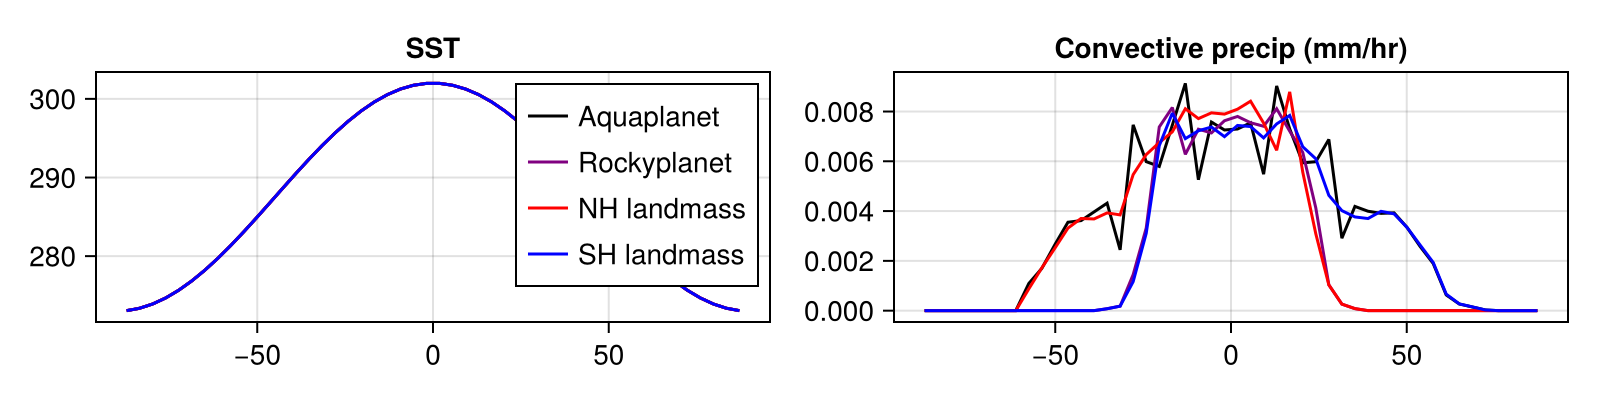

In [41]:
m2mm_hr = (1000*Hour(1)/Hour(180*24)) 
(; rain_large_scale, rain_convection) = simulation1.diagnostic_variables.physics
precip1 = m2mm_hr*rain_convection
sst1 = simulation1.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation2.diagnostic_variables.physics
precip2 = m2mm_hr*rain_convection
sst2 = simulation2.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation3.diagnostic_variables.physics
precip3 = m2mm_hr*rain_convection
sst3 = simulation3.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation4.diagnostic_variables.physics
precip4 = m2mm_hr*rain_convection
sst4 = simulation4.prognostic_variables.ocean.sea_surface_temperature


(; Grid, nlat_half) = model1.spectral_grid
latd = RingGrids.get_latd(Grid, nlat_half)

fig = Figure(size = (800, 200));
axs = [Axis(fig[row, col]) for row in 1: 1, col in 1:2]

l1 = lines!(axs[1,1], latd, zonal_mean(sst1),color=:black)
l2 = lines!(axs[1,1], latd, zonal_mean(sst2),color=:purple)
l3 = lines!(axs[1,1], latd, zonal_mean(sst3),color=:red)
l4 = lines!(axs[1,1], latd, zonal_mean(sst4),color=:blue)
axs[1,1].title = "SST"
axislegend(axs[1,1], [l1, l2, l3, l4], ["Aquaplanet", "Rockyplanet","NH landmass","SH landmass"], position = (1,1), orientation = :vertical)

l1 = lines!(axs[1,2], latd, zonal_mean(precip1),color=:black)
l2 = lines!(axs[1,2], latd, zonal_mean(precip2),color=:purple)
l3 = lines!(axs[1,2], latd, zonal_mean(precip3),color=:red)
l4 = lines!(axs[1,2], latd, zonal_mean(precip4),color=:blue)
axs[1,2].title = "Convective precip (mm/hr)"

fig

## 4️⃣ ❄️🔥 NH cooling only, SH warming only and NH cooling + SH warming experiments

In [48]:
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)
# ocean = ConstantOceanClimatology(spectral_grid) # the sst profile keeps changing over time
ocean = AquaPlanet(spectral_grid, temp_equator=302.0, temp_poles=273.0, mask=true)

# Experiment-1: CONTROL AQUAPLANET 
model1 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation1 = initialize!(model1)
run!(simulation1, period=Day(180))

# Experiment-2: NH Cooling by 5 deg
model2 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation2 = initialize!(model2)
set!(simulation2, sea_surface_temperature=(λ, φ) -> (0.0 <= φ <= 90.0) ? -5.0 : 0, add=true) 
run!(simulation2, period=Day(180))

# Experiment-3: SH warming by 5 deg
model3 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation3 = initialize!(model3)
set!(simulation3, sea_surface_temperature=(λ, φ) -> (-90.0 <= φ < 0.0) ? 5.0 : 0, add=true) 
run!(simulation3, period=Day(180))

# Experiment-4: NH Cooling + SH warming
model4 = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection, ocean, land_sea_mask, orography)
simulation4 = initialize!(model4)
sst_org = zonal_mean(simulation4.prognostic_variables.ocean.sea_surface_temperature)
set!(simulation4, sea_surface_temperature=(λ, φ) -> (0.0 <= φ <= 90.0) ? -5.0 : 0, add=true) # NH Cooling
set!(simulation4, sea_surface_temperature=(λ, φ) -> (-90.0 <= φ < 0.0) ? 5.0 : 0, add=true) # SH warming
run!(simulation4, period=Day(180))
nothing

Weather is speedy: 100%|██████████████████| Time: 0:00:53 (790.78 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:00:55 (766.24 years/day)
Weather is speedy: 100%|██████████████████| Time: 0:07:20 (96.64 years/day)m
Weather is speedy: 100%|██████████████████| Time: 0:02:09 (328.58 years/day)


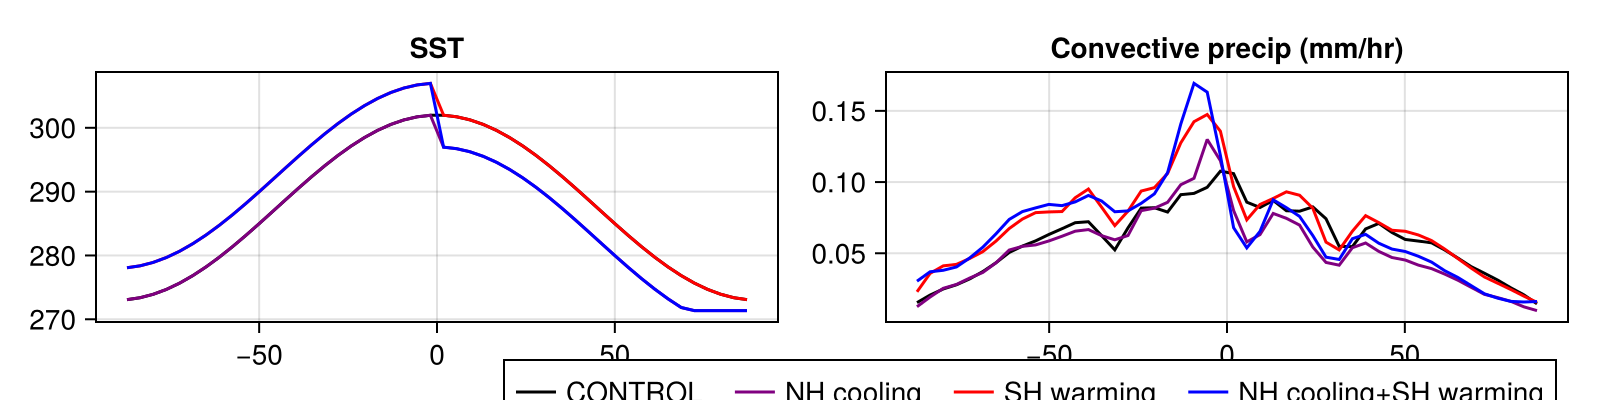

In [49]:
m2mm_hr = (1000*Hour(1)/Hour(180*24)) 
(; rain_large_scale, rain_convection) = simulation1.diagnostic_variables.physics
precip1 = m2mm_hr*rain_convection
sst1 = simulation1.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation2.diagnostic_variables.physics
precip2 = m2mm_hr*rain_convection
sst2 = simulation2.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation3.diagnostic_variables.physics
precip3 = m2mm_hr*rain_convection
sst3 = simulation3.prognostic_variables.ocean.sea_surface_temperature

(; rain_large_scale, rain_convection) = simulation4.diagnostic_variables.physics
precip4 = m2mm_hr*rain_convection
sst4 = simulation4.prognostic_variables.ocean.sea_surface_temperature

(; Grid, nlat_half) = model1.spectral_grid
latd = RingGrids.get_latd(Grid, nlat_half)

fig = Figure(size = (800, 200));
axs = [Axis(fig[row, col]) for row in 1: 1, col in 1:2]

l1 = lines!(axs[1,1], latd, zonal_mean(sst1),color=:black)
l2 = lines!(axs[1,1], latd, zonal_mean(sst2),color=:purple)
l3 = lines!(axs[1,1], latd, zonal_mean(sst3),color=:red)
l4 = lines!(axs[1,1], latd, zonal_mean(sst4),color=:blue)
axs[1,1].title = "SST"

l1 = lines!(axs[1,2], latd, zonal_mean(precip1),color=:black)
l2 = lines!(axs[1,2], latd, zonal_mean(precip2),color=:purple)
l3 = lines!(axs[1,2], latd, zonal_mean(precip3),color=:red)
l4 = lines!(axs[1,2], latd, zonal_mean(precip4),color=:blue)
axs[1,2].title = "Convective precip (mm/hr)"
axislegend(axs[1,2], [l1, l2, l3, l4], ["CONTROL", "NH cooling","SH warming","NH cooling+SH warming"], position = (1,-0.70), orientation = :horizontal)

fig

# 🌏⚖️ Earth-like planet (stable configuration for long simulations)

⚠️ Note that in the following configuration, any change made to sst using `set!` only sets the initial SST conditions, but SST in the next timesteps will change. To ensure the SST (and any changes made therein) remains constant, either AquaPlanet or ConstantOceanClimatology should be chosen as the ocean model. 

In [50]:
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveWetModel, path="./", id="exp_02", output_dt=Minute(360))

# Parameterisation choices
vertical_advection = WENOVerticalAdvection(spectral_grid)
temperature=LandBucketTemperature(spectral_grid) 
soil_moisture=LandBucketMoisture(spectral_grid)
land = LandModel(spectral_grid; temperature, soil_moisture)
land_sea_mask = EarthLandSeaMask(spectral_grid)
orography = EarthOrography(spectral_grid)
ocean = SlabOcean(spectral_grid, mixed_layer_depth=50, mask=true) # mask sst where land mask is true
albedo = Albedo(ocean=OceanSeaIceAlbedo(spectral_grid), land=AlbedoClimatology(spectral_grid))

time_stepping = Leapfrog(spectral_grid, Δt_at_T31=Minute(20))
# change the time scheme to be more off-centred and enable other waves than Kelvin and WMMRGs.
# implicit = ImplicitPrimitiveEq(spectral_grid, \alpha=0.5...1)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; vertical_advection, time_stepping, land, land_sea_mask, orography, ocean, albedo, output)

simulation = initialize!(model)
# now offset SST via set! with add=true
# only changes the initial SST condition
set!(simulation, sea_surface_temperature=(λ, φ) -> 3.0, add=true) 

# To add all diagnostics to the model
# # add!(model, SpeedyWeather.AllOutputVariables()...)
# output only some variables
add!(model, SpeedyWeather.OceanOutput()...)
# add!(model, SpeedyWeather.LandOutput()...)
add!(model, SpeedyWeather.RadiationOutput()...)
add!(model, SpeedyWeather.PrecipitationOutput()...)
# add!(model, SpeedyWeather.TemperatureOutput()...)
# add!(model, SpeedyWeather.SurfaceFluxesOutput()...)

# # Finally, let us run the model
run!(simulation, period=Year(1), output=true) 

nothing

Weather is speedy: run_exp_02_0001 100%|██| Time: 0:08:57 (160.79 years/day)
